# Cluster Overview
The purpose of this notebook is to look and generate any plots needed in the paper.  The purpose of each cell is explained above with a markdown.  Each must be run in succession in case of reusing variables

### Load the DataSet

In [65]:
# Cell loads the data

from Functions import data_loader, get_descriptors, one_filter, data_scaler
import os, sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
from sklearn import preprocessing
from sklearn.cluster import KMeans
from Functions import make_pca_agg_fit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )
X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
# removes catagorical varaiables
test=data.drop(["MOF ID","topology","First nodular character","Second nodular character"],axis=1)
#g_comp=5
# all vs just used !!!! uncomment below for just feature used anaylsis
g_comp=6
test=test[['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']]
g=preprocessing.StandardScaler().fit_transform(test)
g=pd.DataFrame(g)
g.columns=test.columns
test=g

### Generated pca plot of predictive features

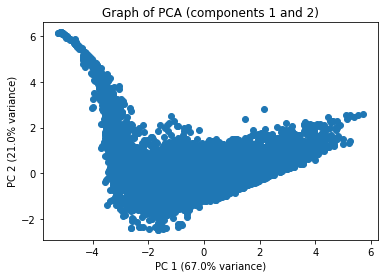

In [66]:
var=.9
_,_,color=make_pca_agg_fit(1,test,var,g_comp,func_give=KMeans,array_out=True)
Out=PCA(n_components=2)
f=Out.fit(test)
a=f.transform(test)
pc1=a.T[:][0]
pc2=a.T[:][1]
plt.scatter(pc1,pc2)
plt.title("Graph of PCA (components 1 and 2)")
plt.xlabel(f"PC 1 ({round(f.explained_variance_ratio_[0],2)*100}% variance)")
plt.ylabel(f"PC 2 ({round(f.explained_variance_ratio_[1],2)*100}% variance)")
#plt.savefig("PCA Graph.png",dpi=400)
plt.show()

### Generated generic cluster plot with bisect to see component importance in PCA

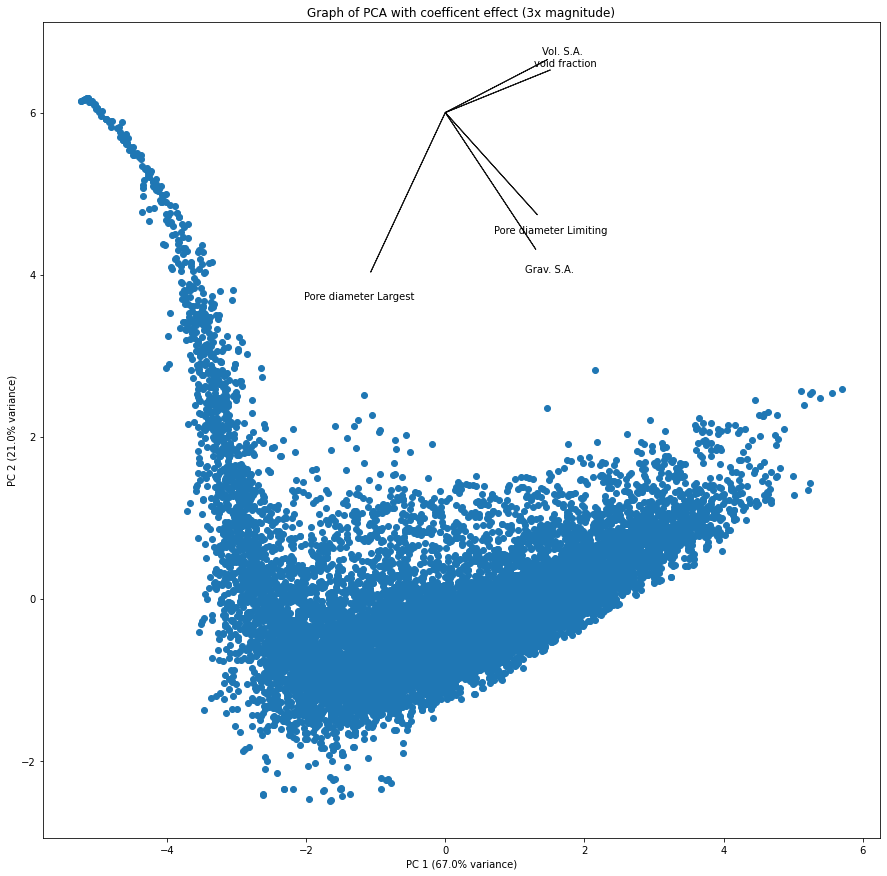

In [67]:
Out=PCA(n_components=2)
f=Out.fit(test)
a=f.transform(test)
pc1=a.T[:][0]
pc2=a.T[:][1]
plt.figure()
plt.scatter(pc1,pc2)
plt.title("Graph of PCA with coefficent effect (3x magnitude)")
plt.xlabel(f"PC 1 ({round(f.explained_variance_ratio_[0],2)*100}% variance)")
plt.ylabel(f"PC 2 ({round(f.explained_variance_ratio_[1],2)*100}% variance)")
score=a[:,0:5]
coeff=np.transpose(f.components_[0:2, :])
y=test.columns
xs = score[:,0] # projection on PC1
ys = score[:,1] # projection on PC2
n = coeff.shape[0] # number of variables
classes = np.unique(y)
coeff=coeff*3
for i in range(n):
    #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
    plt.arrow(0, 6, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1, overhang=0.2)
    plt.text(coeff[i,0]* 1.15, 6+coeff[i,1] * 1.15, classes[i], color = 'k', ha = 'center', va = 'center',fontsize=10)
plt.gcf().set_size_inches(15, 15)
#plt.savefig("Bisect_plot.png",dpi=400)
plt.show()

### Generate Generic Clusters graph

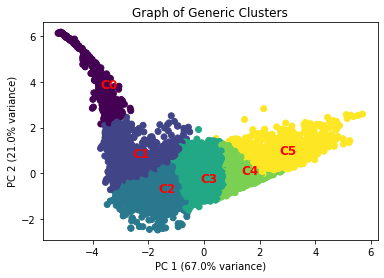

In [68]:
Out=PCA(n_components=2)
g=Out.fit(test)
data2=data.copy()
g_comp=6
holder=['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
for i in holder:
    temp=data2[holder]
    g=preprocessing.StandardScaler().fit_transform(temp)
    g=pd.DataFrame(g)
pc1,pc2,color=make_pca_agg_fit(1,g,var,g_comp,func_give=KMeans,array_out=True)
dic={
    "Pc1" : pc1,
    "Pc2" : pc2,
    "Cluster" : color,
}
holder=pd.DataFrame(dic)
data2=pd.concat([data2,holder],axis=1)
Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
def manual_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y=0
    elif x == 2:
        y= 1
    elif x== 1:
        y=2
    elif x == 4:
        y=3
    elif x == 0:
        y=4
    else:
        y=5
    return y
data2["Cluster"]=data2["Cluster"].apply(manual_swap)
fig=plt.scatter(data2["Pc1"],data2["Pc2"],c=data2["Cluster"])
plt.title("Graph of Generic Clusters")
plt.xlabel(f"PC 1 ({round(f.explained_variance_ratio_[0],2)*100}% variance)")
plt.ylabel(f"PC 2 ({round(f.explained_variance_ratio_[1],2)*100}% variance)")
abridge=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']]
new=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']].groupby("Cluster").mean()
#plt.scatter(new["Pc1"],new["Pc2"],c="r")
annotations=["C0","C1","C2","C3","C4","C5"]
for i, label in enumerate(annotations):
    plt.annotate(label, (new["Pc1"][i],new["Pc2"][i]),weight='bold',c="r",size=12)
#plt.savefig("Generic_Cluster.png",dpi=400)

In [69]:
Cluster_colors=[
[0.267004, 0.004874, 0.329415, 1.      ],
[0.253935, 0.265254, 0.529983, 1.      ],
[0.163625, 0.471133, 0.558148, 1.      ],
[0.134692, 0.658636, 0.517649, 1.      ],
[0.477504, 0.821444, 0.318195, 1.      ],
[0.993248, 0.906157, 0.143936, 1.      ],]
def map_colors(df,colors):
    dic={}
    for i in df["Cluster"].unique():
        dic[i]=colors[i]
    df["color"]=df["Cluster"].map(dic)
    return df
display(map_colors(hold,Cluster_colors))

,Pc1,Pc2,Cluster,H2@100 bar/130K (wt%),color,CH4@100 bar/298 K (mg/g),5 bar Xe mol/kg,5 bar Kr mol/kg
0,-3.103060,0.261744,1,0.093434,"[0.253935, 0.265254, 0.529983, 1.0]",0.074528,0.528090,0.388889
1,-3.039169,1.011479,1,0.080808,"[0.253935, 0.265254, 0.529983, 1.0]",0.061510,0.460674,0.305556
2,-2.801839,-0.529992,2,0.103535,"[0.163625, 0.471133, 0.558148, 1.0]",0.088063,0.370787,0.375000
3,-2.712230,-0.549548,2,0.090909,"[0.163625, 0.471133, 0.558148, 1.0]",0.073805,0.146067,0.208333
4,-2.441665,-0.861798,2,0.118687,"[0.163625, 0.471133, 0.558148, 1.0]",0.103320,0.179775,0.263889
...,...,...,...,...,...,...,...,...
13501,-2.375941,0.626466,1,0.098485,"[0.253935, 0.265254, 0.529983, 1.0]",0.077731,0.348315,0.333333
13502,-1.824971,0.419623,1,0.113636,"[0.253935, 0.265254, 0.529983, 1.0]",0.095192,0.235955,0.291667
13503,-1.589320,0.898877,1,0.123737,"[0.253935, 0.265254, 0.529983, 1.0]",0.101357,0.494382,0.402778
13504,-2.387767,0.838841,1,0.103535,"[0.253935, 0.265254, 0.529983, 1.0]",0.083655,0.438202,0.375000


### Generate Generic Clusters graph versus preformance for each task

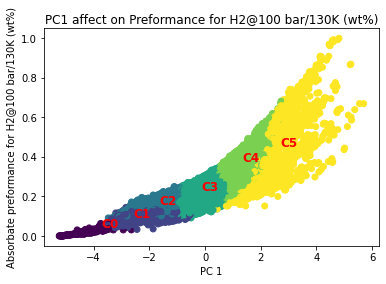

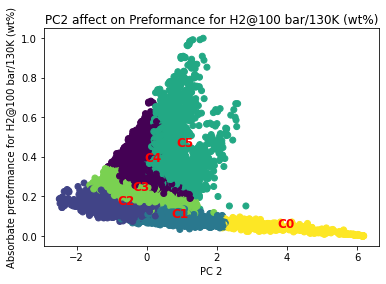

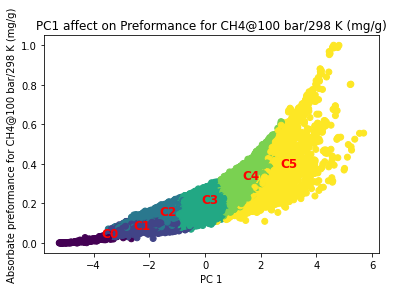

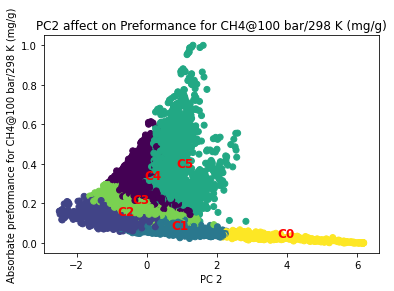

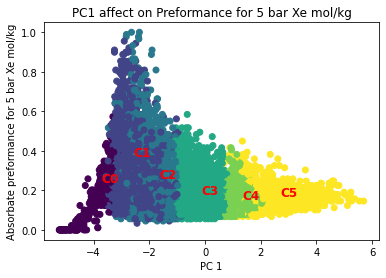

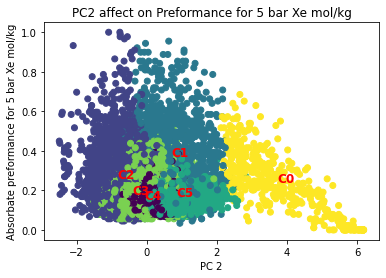

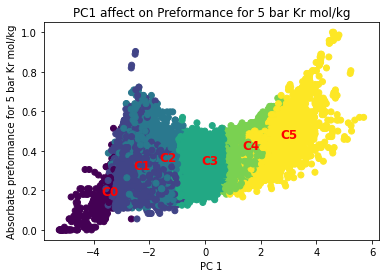

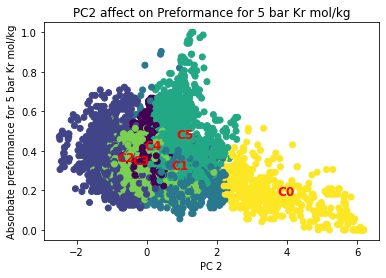

In [70]:

from sklearn.preprocessing import MinMaxScaler
hold=pd.DataFrame()
tasks=['H2@100 bar/130K (wt%)', 'CH4@100 bar/298 K (mg/g)', '5 bar Xe mol/kg', '5 bar Kr mol/kg']
for i in tasks:
    scaled=MinMaxScaler().fit_transform((data[i]).to_numpy().reshape(-1,1))
    hold[['Pc1', 'Pc2',"Cluster"]]=data2[['Pc1', 'Pc2',"Cluster"]]
    hold[i]=scaled
    new=hold.groupby("Cluster").mean()
    hold=(map_colors(hold,Cluster_colors))
    plt.title(f"PC1 affect on Preformance for {i}")
    plt.xlabel(f"PC 1")
    plt.ylabel(f"Absorbate preformance for {i}")
    plt.scatter(pc1,scaled,c=hold["color"])
    annotations=["C0","C1","C2","C3","C4","C5"]
    for z, label in enumerate(annotations):
        plt.annotate(label, (new["Pc1"][z],new[i][z]),weight='bold',c="r",size=12)
    #plt.savefig(f"Generic_{i[:7]}_PC1.png",dpi=400)
    plt.show()
    plt.title(f"PC2 affect on Preformance for {i}")
    plt.xlabel(f"PC 2")
    plt.ylabel(f"Absorbate preformance for {i}")
    plt.scatter(pc2,scaled,c=color)
    for z, label in enumerate(annotations):
        plt.annotate(label, (new["Pc2"][z],new[i][z]),weight='bold',c="r",size=12)
    #plt.savefig(f"Generic_{i[:7]}_PC2.png",dpi=400)
    plt.show()

### Generate outline of PCA points (not used directly)

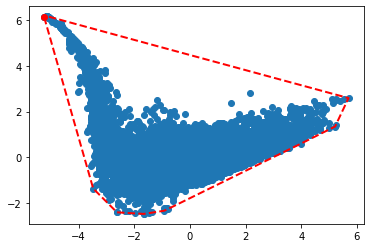

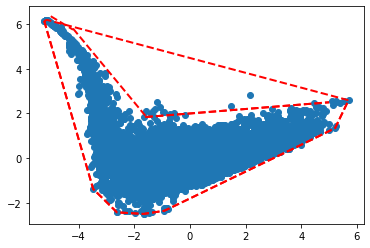

In [71]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
alpha_tuples=[[a,b] for a,b in zip(data2["Pc1"].to_numpy(),data2["Pc2"].to_numpy())]
alpha_tuples=np.array(alpha_tuples)
hull=ConvexHull(alpha_tuples)
plt.plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
plt.plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices[0],0], alpha_tuples[hull.vertices[0],1], 'ro')
plt.show()
plt.plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
plt.plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
x=np.linspace(-4.2,-1.6,1001)
y= lambda x: -.5 - 1.5*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-5,-4.2,1001)
y= lambda x: 2.6- .75*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)

### Generate pie charts of Clusters by topology (Not Used)

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/1435333844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge[f"Cluster {i}"]=abridge["MOF ID"]


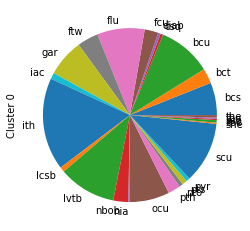

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/1435333844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge[f"Cluster {i}"]=abridge["MOF ID"]


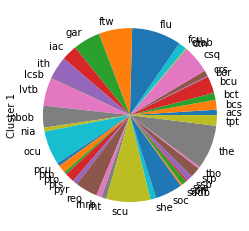

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/1435333844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge[f"Cluster {i}"]=abridge["MOF ID"]


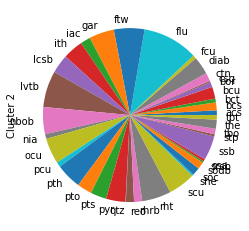

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/1435333844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge[f"Cluster {i}"]=abridge["MOF ID"]


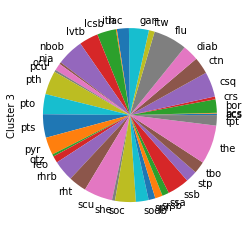

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/1435333844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge[f"Cluster {i}"]=abridge["MOF ID"]


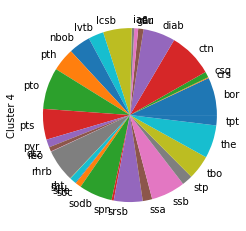

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/1435333844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge[f"Cluster {i}"]=abridge["MOF ID"]


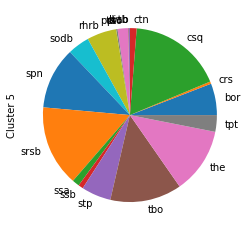

In [72]:
for i in range(6):
    abridge[f"Cluster {i}"]=abridge["MOF ID"]
    Cluster1=abridge[abridge["Cluster"]==i]
    Cluster1.groupby("topology").count()[f"Cluster {i}"].plot.pie(y=f"Cluser {i}")
    plt.show()

### Generate topology distributions by generic cluster

FileNotFoundError: [Errno 2] No such file or directory: 'topology_historgrams/acs_distribution.png'

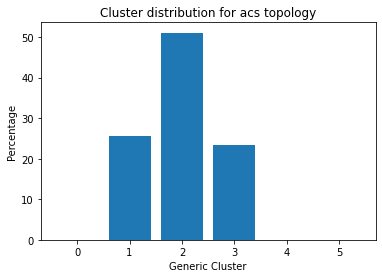

In [73]:
dic={}
for i in abridge["topology"].unique():
    dic[i]=[]
for i in range(6):
    Cluster1=abridge[abridge["Cluster"]==i]
    for j in abridge["topology"].unique():
        if sum(Cluster1["topology"]==j) > 0:
            dic[j].append(sum(Cluster1["topology"]==j))
        else:
            dic[j].append(0)
for i in dic:
    dic[i]=np.array(dic[i])
    dic[i]=(dic[i]/sum(dic[i]))*100
    plt.bar([0,1,2,3,4,5],dic[i])
    plt.title(f"Cluster distribution for {i} topology")
    plt.ylabel("Percentage")
    plt.xlabel("Generic Cluster")
    plt.savefig(f"topology_historgrams/{i}_distribution.png",dpi=400)
    plt.show()

### Generate topology points on PCA outline

/var/folders/8g/ksnlbxsx4svgsy08zrk0cm900000gn/T/ipykernel_92144/3337965058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color"]=df["Cluster"].map(dic)
/Users/gregcooper/opt/anaconda3/envs/Transfer/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


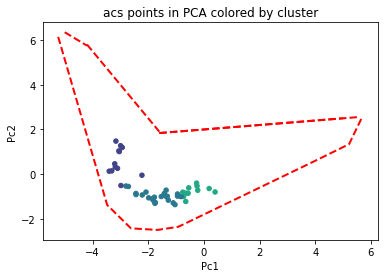

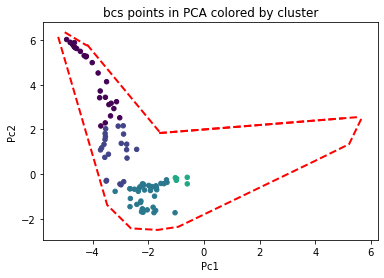

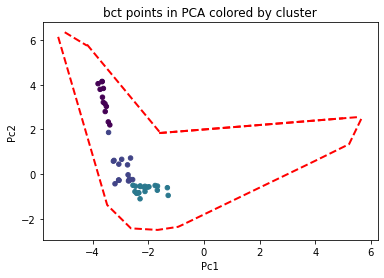

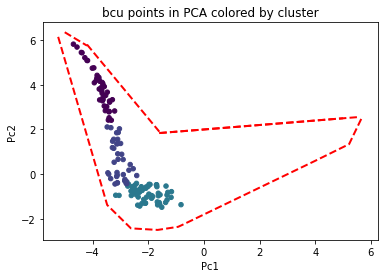

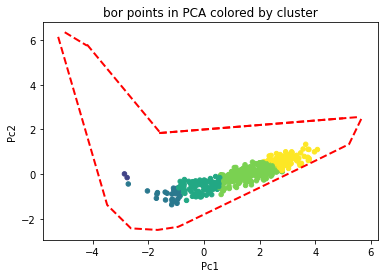

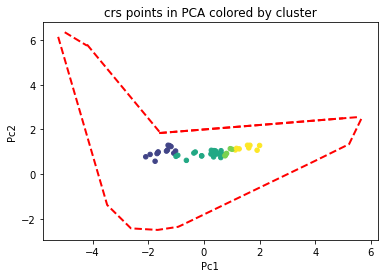

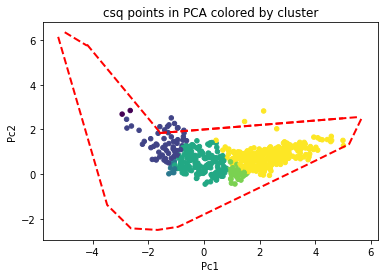

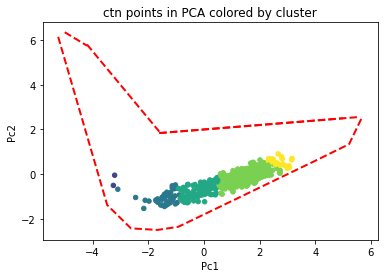

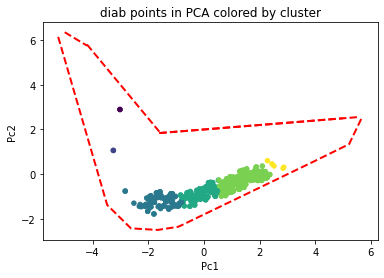

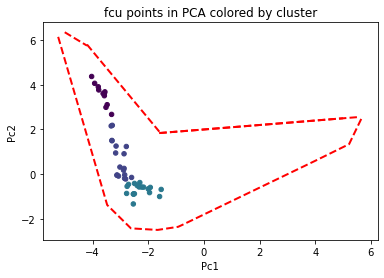

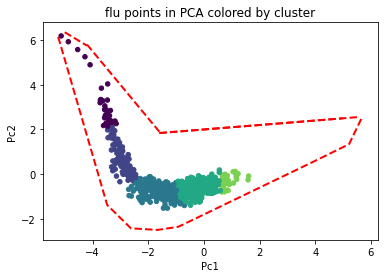

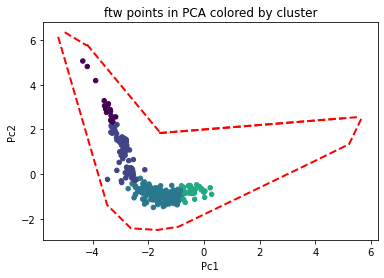

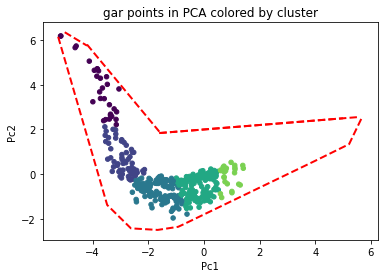

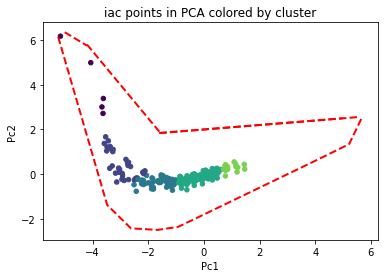

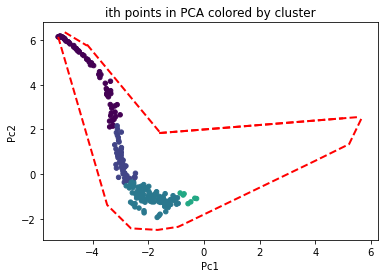

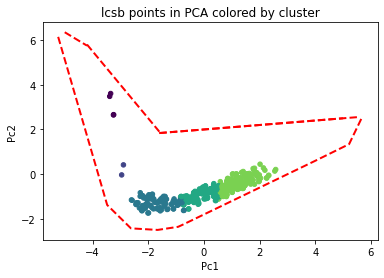

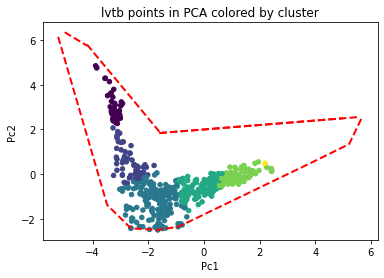

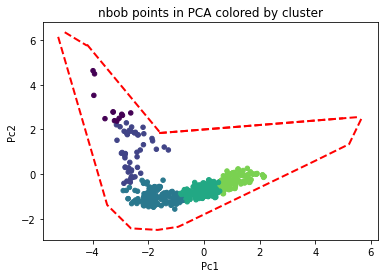

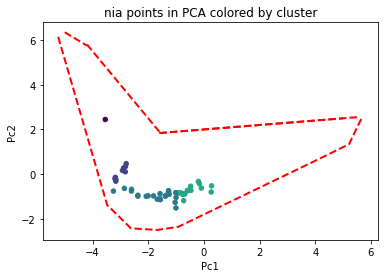

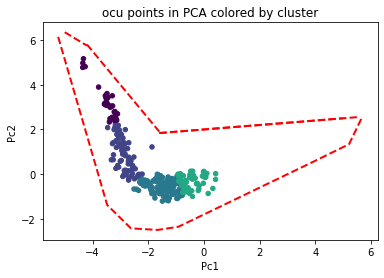

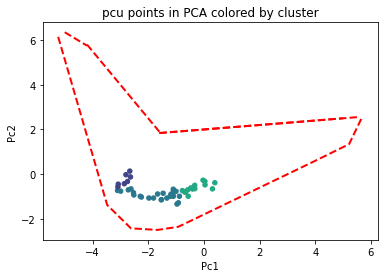

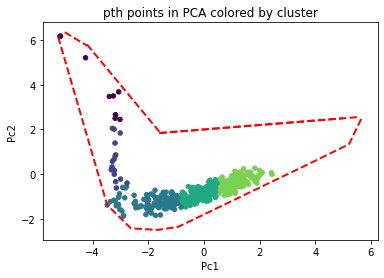

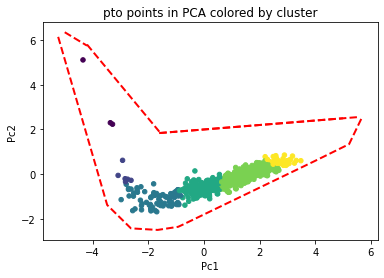

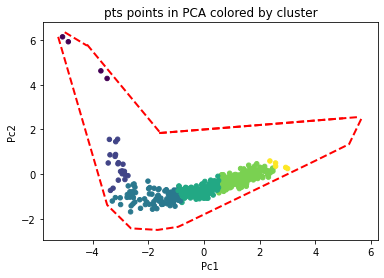

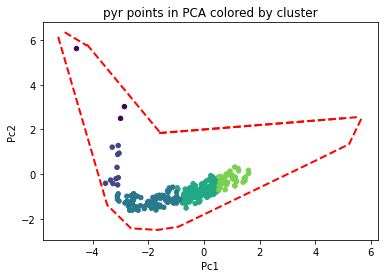

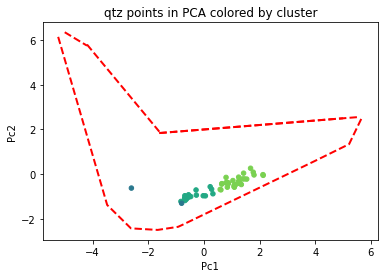

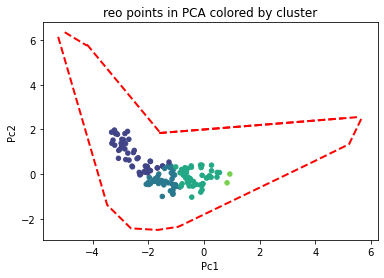

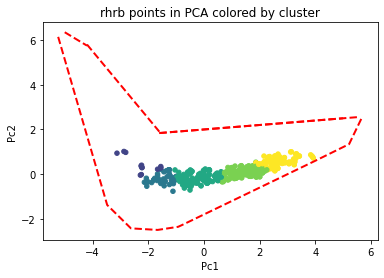

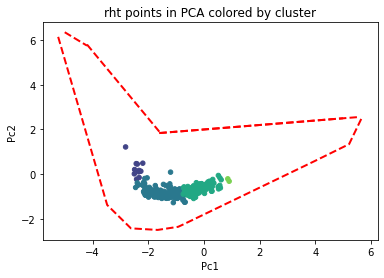

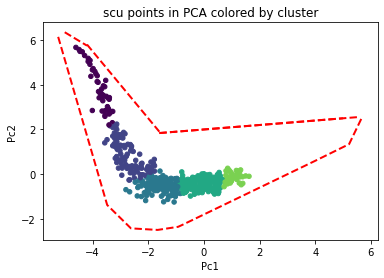

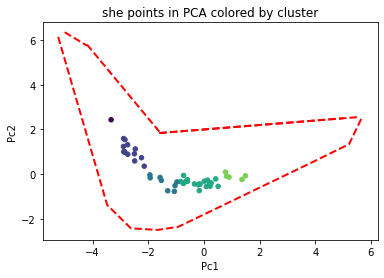

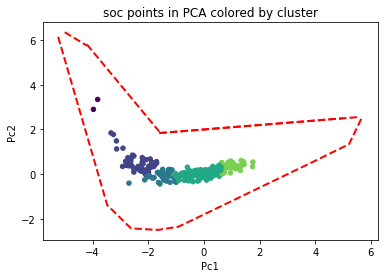

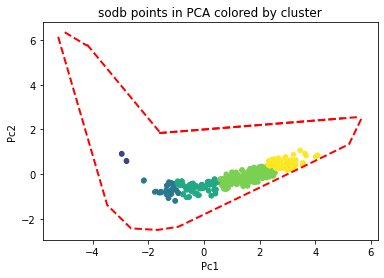

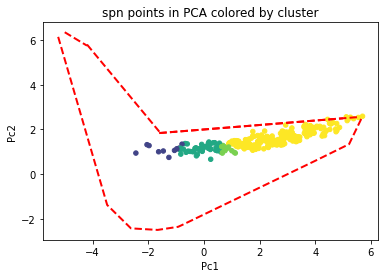

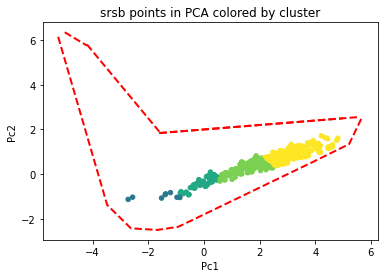

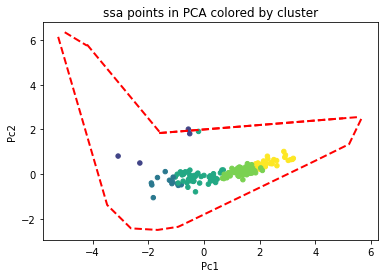

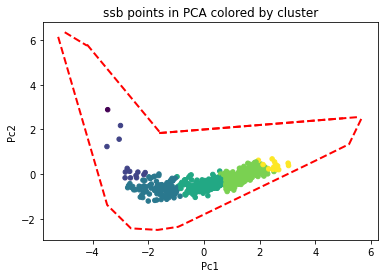

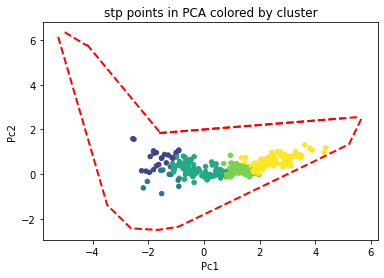

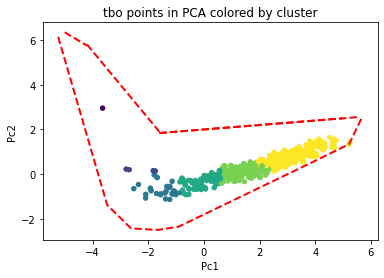

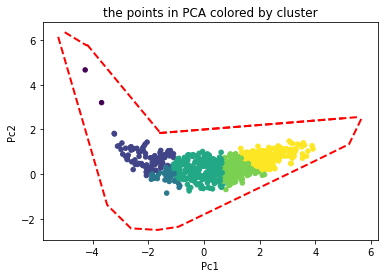

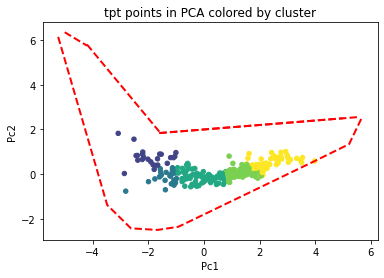

In [74]:
def color_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y="r"
    elif x == 2:
        y= "b"
    elif x== 1:
        y="g"
    elif x == 4:
        y= "y"
    elif x == 0:
        y= "m"
    else:
        y="c"
    return y
abridge=map_colors(abridge,Cluster_colors)
for i in (abridge["topology"].unique()):
    interest=i
    abridge[abridge["topology"]==interest][["Pc1","Pc2","Cluster"]].plot.scatter(x="Pc1",y="Pc2",c=abridge[abridge["topology"]==interest]["color"])
    plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
    #plt.savefig(f"topology_outline/{i}_cluster_out.png",dpi=400)

### Generate topology map by median or mean

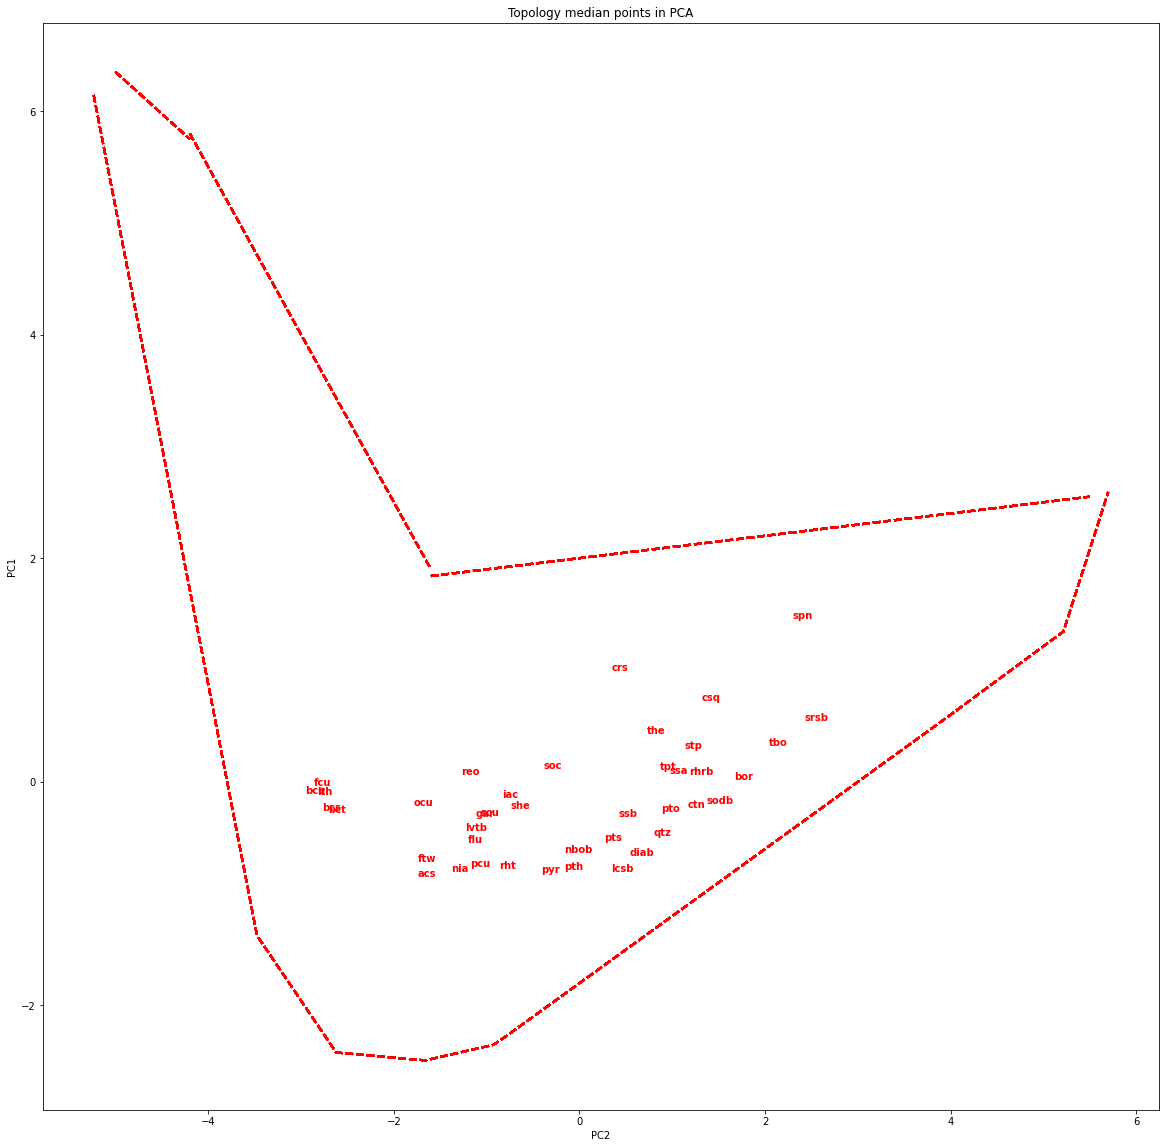

In [9]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
median=True
for z,i in enumerate(abridge["topology"].unique()):
    interest=i
    if median:
        abridge[abridge["topology"]==interest][["Pc1","Pc2"]].median()
        a,b=abridge[abridge["topology"]==interest][["Pc1","Pc2"]].median().to_numpy()
    if not median:
        abridge[abridge["topology"]==interest][["Pc1","Pc2"]].mean()
        a,b=abridge[abridge["topology"]==interest][["Pc1","Pc2"]].mean().to_numpy()
    plt.annotate(interest, (a,b),weight='bold',c="r",size=10)
    plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
if median:
    plt.title("Topology median points in PCA")
else:
    plt.title("Topology mean points in PCA")
plt.ylabel("PC1")
plt.xlabel("PC2")
loud=False
if loud:
    if median:
        plt.savefig("Topology_median.png",dpi=400)
    else:
        plt.savefig("Topology_mean.png",dpi=400)

### Color topology by generic cluster

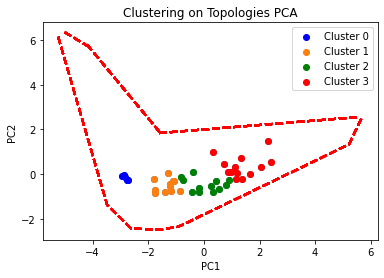

In [163]:

a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
plt.scatter(a["Pc1"],a["Pc2"])
color = AgglomerativeClustering(n_clusters=4).fit_predict(a)
color=np.array(color)
holder=[0,2,1,3]
for i in reversed(holder):
    ix = np.where(color == i)
    if i ==3:
        label=("Cluster 0")
        l_c="b"
    elif i ==2:
        label=("Cluster 2")
        l_c="g"
    elif i ==1:
        label=("Cluster 1")
        l_c="tab:orange"
    elif i ==0:
        label=("Cluster 3")
        l_c="r"
    plt.scatter(a["Pc1"].iloc[ix],a["Pc2"].iloc[ix],c=l_c,label=label)
plt.legend()
distances=pd.DataFrame(distance_matrix(a,a),index=a.index,columns=a.index)
distances
for z,i in enumerate(abridge["topology"].unique()):
    interest=i
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("Clustering on Topologies PCA")
plt.legend()
plt.savefig("Topology_clusters.png",dpi=400)
plt.show()

### Hierarchical clustering dendrogram

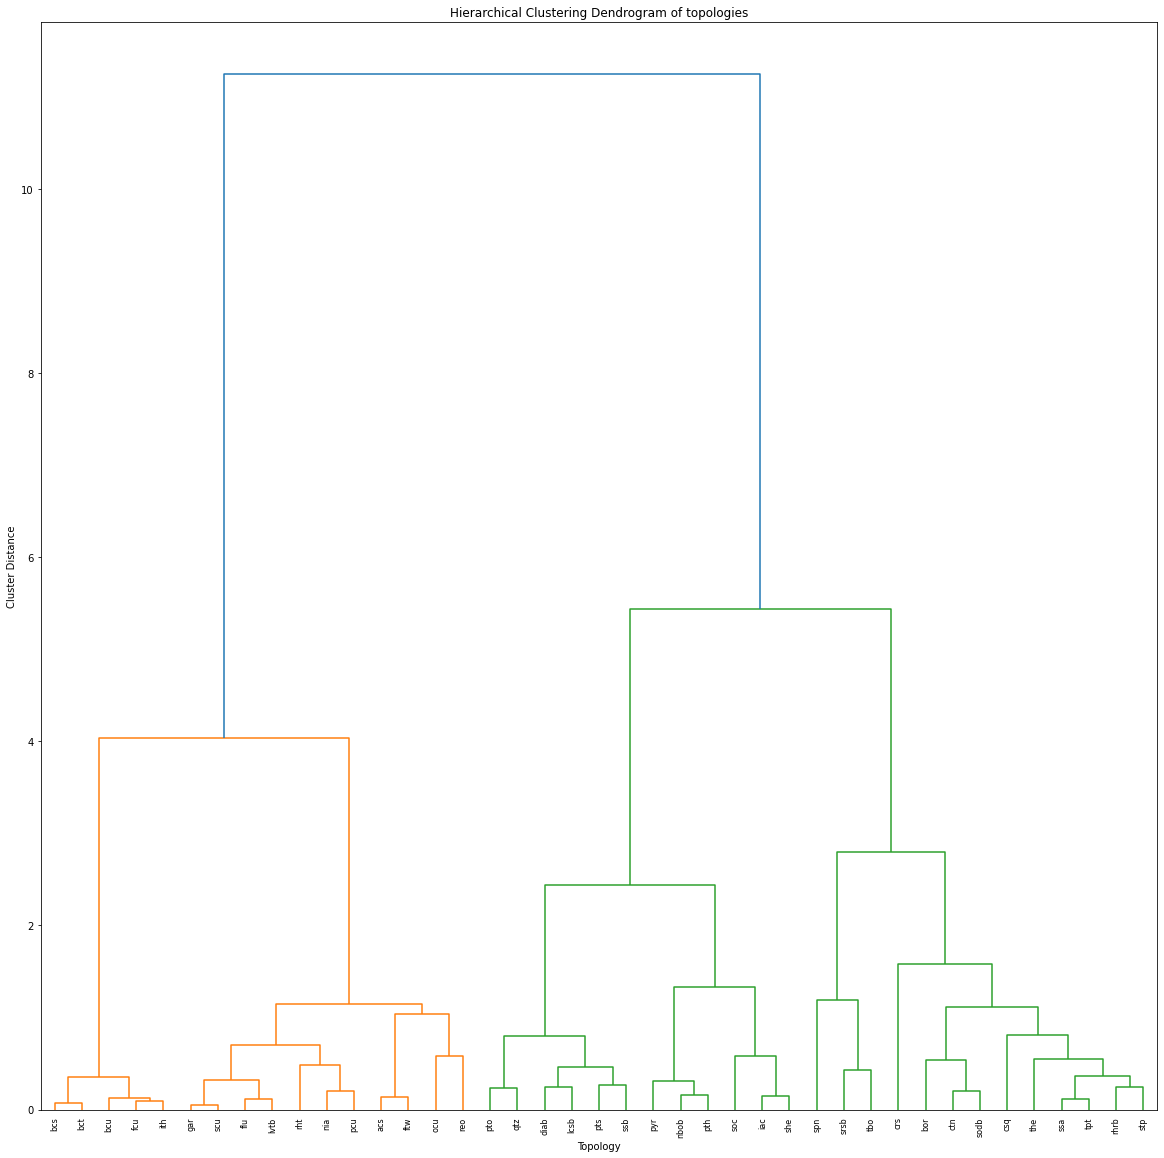

In [ ]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    
    dendrogram(linkage_matrix, labels=a.index,orientation='top')


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(a)
    
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
plt.ylabel("Cluster Distance")
plt.xlabel("Topology")
plt.title("Hierarchical Clustering Dendrogram of topologies")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=1)
#plt.savefig("Hierarchical.png",dpi=400)